# 微博大V的公共影响力

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import statsmodels.api as sm
from collections import Counter, defaultdict
matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei'] #指定默认字体  

In [3]:
def alloRegressPlot(xdata,ydata,col,mark,xlab,ylab, loglog):
    x=np.log(xdata+1);y=np.log(ydata+1);
    #x=np.log(xdata);y=np.log(ydata);
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant=res.params[0];beta=res.params[1]; r2=res.rsquared
    plt.plot(xdata,ydata,mark,color=col)
    if loglog == True:
        plt.xscale('log');plt.yscale('log')
    plt.xlabel(xlab);plt.ylabel(ylab)
    minx,maxx=plt.xlim(); miny,maxy=plt.ylim()
    plt.text(min(xdata)+(max(xdata)-min(xdata))/10,
         min(ydata)+(max(ydata)-min(ydata))/2,
         '$\\alpha$ = '+ str(np.round(beta,2)) + ' , ' \
         + '$R^2$ = ' + str(np.round(r2,2)) )
    xs = np.linspace(min(xdata),max(xdata),100)
    plt.plot(xs,np.exp(constant)*xs**beta,color='r',linestyle='-')

def linearRegressPlot(xdata,ydata,col,mark,xlab,ylab):
    x=xdata;y=ydata
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant=res.params[0];beta=res.params[1]; r2=res.rsquared
    plt.plot(xdata,ydata,mark,color=col)
    plt.xlabel(xlab);plt.ylabel(ylab)
    minx,maxx=plt.xlim(); miny,maxy=plt.ylim()
    plt.text(min(xdata)+(max(xdata)-min(xdata))/10,
         min(ydata)+(max(ydata)-min(ydata))/2,
         '$\\alpha$ = '+ str(np.round(beta,2)) + ' , ' \
         + '$R^2$ = ' + str(np.round(r2,2)) )
    xs = np.linspace(min(xdata),max(xdata),100)
    plt.plot(xs,constant + xs*beta,color='r',linestyle='-')

# 基于事件类型的微博公众人物排行榜

## 读入并清洗数据

In [12]:
df = pd.read_csv('/Users/chengjun/github/cjc/data/weiboHits.txt',   encoding = 'gb18030', 
                delimiter='\t', header = 0)

In [13]:
df[:5]

,id,starname,议题,发文数,总评论数,总转发数,总点赞数
0,1.0,周国平,国家议程,0.0,0.0,0.0,0.0
1,1.0,周国平,公权政策,0.0,0.0,0.0,0.0
2,1.0,周国平,法律案例,1.0,270.0,526.0,248.0
3,1.0,周国平,社会矛盾,0.0,0.0,0.0,0.0
4,1.0,周国平,灾难救助,0.0,0.0,0.0,0.0


In [14]:
df2 = df[df[u'发文数']!=0.0]

In [15]:
len(df), len(df2)

(1673, 1029)

In [18]:
df2[:5]

,id,starname,议题,发文数,总评论数,总转发数,总点赞数
2,1.0,周国平,法律案例,1.0,270.0,526.0,248.0
6,2.0,章诒和,国家议程,10.0,826.0,2800.0,1893.0
7,2.0,章诒和,公权政策,5.0,442.0,1508.0,551.0
8,2.0,章诒和,法律案例,7.0,554.0,1992.0,1701.0
9,2.0,章诒和,社会矛盾,5.0,618.0,2366.0,752.0


In [21]:
df2.rename(columns={u'议题': 'issue', u'发文数': 'num', \
                    u'总评论数': 'comment', u'总转发数':'repost', u'总点赞数':'like'}, inplace=True)

In [22]:
df2[:5]

,id,starname,issue,num,comment,repost,like
2,1.0,周国平,法律案例,1.0,270.0,526.0,248.0
6,2.0,章诒和,国家议程,10.0,826.0,2800.0,1893.0
7,2.0,章诒和,公权政策,5.0,442.0,1508.0,551.0
8,2.0,章诒和,法律案例,7.0,554.0,1992.0,1701.0
9,2.0,章诒和,社会矛盾,5.0,618.0,2366.0,752.0


In [37]:
df2 = df2.dropna()
len(df2)

760

## 描述分析

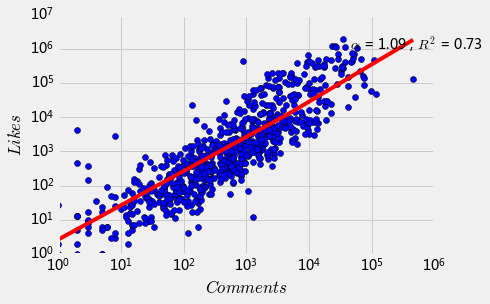

In [41]:
matplotlib.style.use('fivethirtyeight')

alloRegressPlot(np.array(df2.comment), np.array(df2.like),\
                'blue','o','$Comments$','$Likes$', loglog=True)

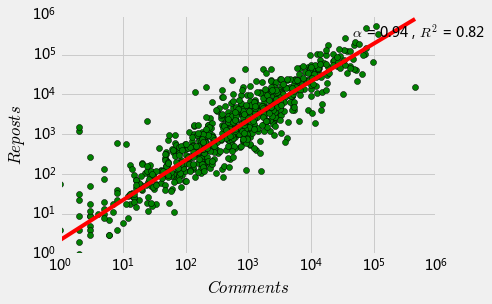

In [43]:
matplotlib.style.use('fivethirtyeight')

alloRegressPlot(np.array(df2.comment), np.array(df2.repost),\
                'green','o','$Comments$','$Reposts$', loglog=True)

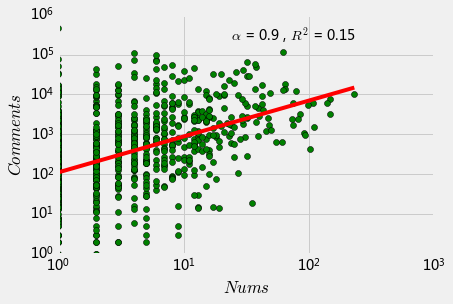

In [44]:
matplotlib.style.use('fivethirtyeight')

alloRegressPlot(np.array(df2.num), np.array(df2.comment),\
                'green','o','$Nums$','$Comments$', loglog=True)

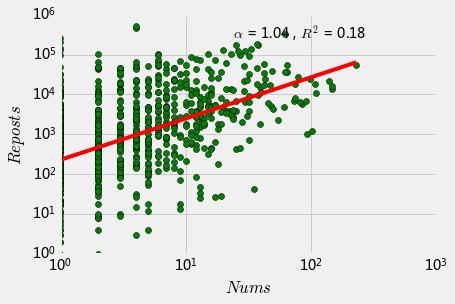

In [46]:
matplotlib.style.use('fivethirtyeight')

alloRegressPlot(np.array(df2.num), np.array(df2.repost),\
                'green','o','$Nums$','$Reposts$', loglog=True)

## 参与度

- 基本假设1：一个好的“Authority”页面会被很多好的“Hub”页面指向；
- 基本假设2：一个好的“Hub”页面会指向很多好的“Authority”页面；

Hub --> Authority

In [89]:
G = nx.DiGraph()
for i in df2.index:
    G.add_edge(df2.starname[i], df2.issue[i], weight = df2.num[i])

In [90]:
nx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 239\nNumber of edges: 760\nAverage in degree:   3.1799\nAverage out degree:   3.1799'

In [94]:
h, a = nx.hits(G)

stars =  df2.starname.unique().tolist()
issues = df2.issue.unique().tolist()

hub_dic = {}
for i in stars:
    hub_dic[i]=h[i]
    
star_df = pd.DataFrame(hub_dic.items(), columns = ['star', 'hub_num'])
star_df.sort_values(by = 'hub_num', ascending = False)

,star,hub_num
36,老沉,0.090319
166,胡舒立,0.045833
178,陈士渠,0.042904
86,袁莉wsj,0.038166
135,袁国宝,0.033005
51,罗昌平,0.029902
222,盘锦周恩义,0.029604
52,宋鸿兵,0.023252
84,鞍钢郭明义,0.021244
98,侯宁,0.020755


In [73]:
for i in issues:
    print i, a[i]

法律案例 0.105124364728
国家议程 0.076103313983
公权政策 0.169128698448
社会矛盾 0.0881125038008
灾难救助 0.399284926008
涉外涉军 0.162246193032


In [70]:
star_hub = [h[i] for i in stars] # stars have only hub values
issue_authority = [a[i] for i in issues]

In [71]:
len(star_hub), len(issue_authority)

(233, 6)

## 影响力

In [87]:
G1 = nx.DiGraph()
for i in df2.index:
    G1.add_edge(df2.starname[i], df2.issue[i], weight = df2.repost[i])

In [95]:
h1, a1 = nx.hits(G1)

stars =  df2.starname.unique().tolist()
issues = df2.issue.unique().tolist()

hub_dic1 = {}
for i in stars:
    hub_dic1[i]=h1[i]
    
star_df1 = pd.DataFrame(hub_dic1.items(), columns = ['star', 'hub_influence'])
star_df1.sort_values(by = 'hub_influence', ascending = False)

,star,hub_influence
80,韩寒,1.042157e-01
188,芙蓉姐姐,4.487297e-02
129,黄晓明,4.267078e-02
171,姚晨,4.067966e-02
100,杨幂,3.956712e-02
221,李开复,3.878906e-02
71,加措活佛-慈爱基金,3.604740e-02
211,陈坤,3.259674e-02
163,何炅,3.042808e-02
216,唐嫣,2.987967e-02


In [121]:
for i in issues:
    print i, a1[i]

法律案例 0.0823103603834
国家议程 0.0734241646607
公权政策 0.0354031808585
社会矛盾 0.194502497789
灾难救助 0.496435785085
涉外涉军 0.117924011224


## 合并数据

In [96]:
star_df[:5]

,star,hub_num
0,李晨,0.009045
1,御史在途,0.011898
2,郭斯特,0.000105
3,苏芩,0.002021
4,十年砍柴,0.019317


In [97]:
star_df1[:5]

,star,hub_influence
0,李晨,0.024209
1,御史在途,0.001142
2,郭斯特,0.000759
3,苏芩,0.003314
4,十年砍柴,0.001949


In [100]:
dat = pd.merge(star_df, star_df1, on='star')
dat[:5]

,star,hub_num,hub_influence
0,李晨,0.009045,0.024209
1,御史在途,0.011898,0.001142
2,郭斯特,0.000105,0.000759
3,苏芩,0.002021,0.003314
4,十年砍柴,0.019317,0.001949


In [104]:
# dat.to_csv('/Users/chengjun/github/cjc/data/weiboHits_results.txt', encoding = 'utf8',\
#         sep=',', columns=None, header=True, index=False)

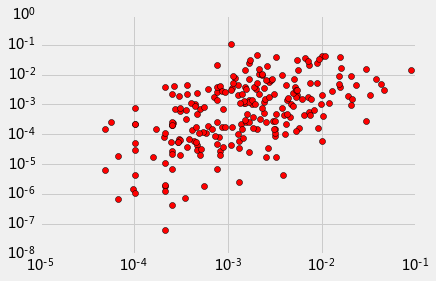

In [106]:
plt.plot(dat.hub_num, dat.hub_influence, 'ro')
plt.xscale('log');plt.yscale('log')
plt.show()

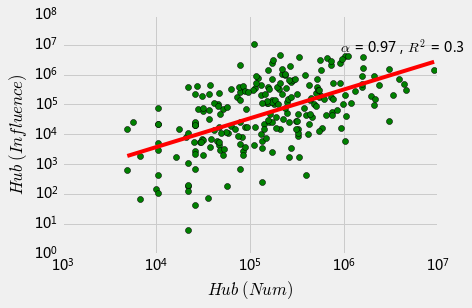

In [120]:
matplotlib.style.use('fivethirtyeight')

alloRegressPlot(np.array(dat.hub_num)*100000000, np.array(dat.hub_influence)*100000000,\
                'green','o','$Hub\;(Num)$','$Hub\;(Influence)$', loglog=True)

# 基于事件的微博公众人物排行榜

## 读入数据

In [45]:
de = pd.read_excel('/Users/chengjun/github/cjc/data/Hits_weibo_events.xlsx',   
                delimiter=',', header = 0)
de[:3]

,user,event,post,trans
0,angelababy,芦山地震,3,7565
1,angelababy,马航失联,2,9979
2,angelababy,女排奥运夺冠,1,31729


In [46]:
de.post.sum(), de.trans.sum(), len(de.event.unique()), len(de.user.unique())

(6962, 8490062, 63, 233)

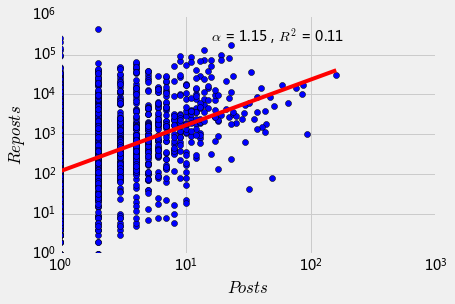

In [47]:
matplotlib.style.use('fivethirtyeight')

alloRegressPlot(np.array(de.post), np.array(de.trans),\
                'blue','o','$Posts$','$Reposts$', loglog=True)

## 计算参与度和影响力

In [48]:
G = nx.DiGraph()
for i in de.index:
    G.add_edge(de.user[i], de.event[i], weight = de.post[i])
    
G1 = nx.DiGraph()
for i in de.index:
    G1.add_edge(de.user[i], de.event[i], weight = de.trans[i])

In [49]:
h, a = nx.hits(G)

stars =  de.user.unique().tolist()
issues = de.event.unique().tolist()

hub_dic = {}
for i in stars:
    hub_dic[i]=h[i]
    
star_df = pd.DataFrame(hub_dic.items(), columns = ['star', 'hub_num'])
star_df.sort_values(by = 'hub_num', ascending = False)[:5]

,star,hub_num
38,老沉,0.156704
170,胡舒立,0.051260
90,袁莉wsj,0.046309
56,宋鸿兵,0.039688
181,陈士渠,0.038170


In [50]:
h1, a1 = nx.hits(G1)

stars =  de.user.unique().tolist()
issues = de.event.unique().tolist()

hub_dic1 = {}
for i in stars:
    hub_dic1[i]=h1[i]
    
star_df1 = pd.DataFrame(hub_dic1.items(), columns = ['star', 'hub_influence'])
star_df1.sort_values(by = 'hub_influence', ascending = False)[:5]

,star,hub_influence
83,韩寒,0.250116
75,加措活佛-慈爱基金,0.074563
204,李开复,0.055236
61,陈坤,0.051161
62,杨幂,0.048763


In [51]:
authority_dic = {}
for i in issues:
    authority_dic[i]=a[i]
    
issue_df = pd.DataFrame(authority_dic.items(), columns = ['issue', 'authority_num'])
issue_df.sort_values(by = 'authority_num', ascending = False)[:5]

,issue,authority_num
51,马航失联,0.197055
37,棱镜门,0.096338
15,薄熙来,0.094438
21,芦山地震,0.065983
23,美国大选,0.062662


In [52]:
authority_dic1 = {}
for i in issues:
    authority_dic1[i]=a1[i]
    
issue_df1 = pd.DataFrame(authority_dic1.items(), columns = ['issue', 'authority_influence'])
issue_df1.sort_values(by = 'authority_influence', ascending = False)[:5]

,issue,authority_influence
21,芦山地震,0.493021
40,南海仲裁案,0.111005
50,穹顶之下,0.051366
27,天津港爆炸,0.037842
51,马航失联,0.037126


## 合并数据

In [53]:
star_dat = pd.merge(star_df, star_df1, on='star')
star_dat[:5]

,star,hub_num,hub_influence
0,李晨,0.006369,9.269666e-03
1,御史在途,0.008121,4.101802e-04
2,郭斯特,0.000040,1.888101e-03
3,撒贝宁,0.000055,7.033468e-07
4,十年砍柴,0.011392,6.217104e-04


In [54]:
event_dat = pd.merge(issue_df, issue_df1, on='issue')
event_dat[:5]

,issue,authority_num,authority_influence
0,海天盛宴事件,0.001049,0.000016
1,房姐事件,0.002198,0.000060
2,G20,0.008399,0.000325
3,校长开房,0.001678,0.002748
4,刘铁男案,0.011594,0.017091


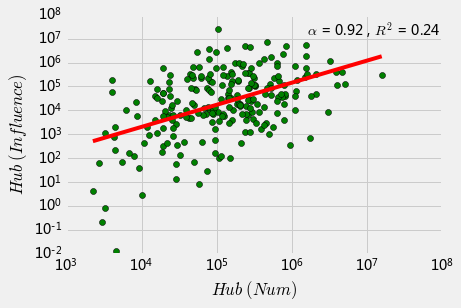

In [55]:
matplotlib.style.use('fivethirtyeight')

alloRegressPlot(np.array(star_dat.hub_num)*100000000, np.array(star_dat.hub_influence)*100000000,\
                'green','o','$Hub\;(Num)$','$Hub\;(Influence)$', loglog=True)

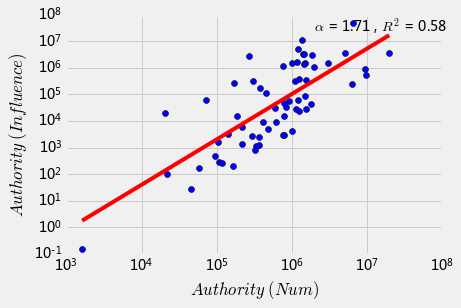

In [56]:
matplotlib.style.use('fivethirtyeight')

alloRegressPlot(np.array(event_dat.authority_num)*100000000, np.array(event_dat.authority_influence)*100000000,\
                'blue','o','$Authority\;(Num)$','$Authority\;(Influence)$', loglog=True)

## 保存数据

In [57]:
event_dat.to_excel('/Users/chengjun/github/cjc/data/Hits_weibo_event_authority.xlsx')

In [58]:
star_dat.to_excel('/Users/chengjun/github/cjc/data/Hits_weibo_star_hub.xlsx')